In [1]:
import pandas as pd

# Cargar tu dataset
df = pd.read_csv("../data/diabetes_multiclass.csv")

# Buscar duplicados exactos en todas las columnas
duplicated_mask = df.duplicated(keep=False)  # keep=False marca todos, no solo los repetidos posteriores
duplicated_rows = df[duplicated_mask]

# Mostrar cuántos duplicados hay en total
print(f"Total de filas duplicadas: {duplicated_rows.shape[0]}")

# Ver cuántos duplicados hay por clase del target
print("\nDistribución de duplicados por clase de Diabetes_012:")
print(duplicated_rows["Diabetes_012"].value_counts())


Total de filas duplicadas: 35086

Distribución de duplicados por clase de Diabetes_012:
Diabetes_012
0.0    34603
2.0      479
1.0        4
Name: count, dtype: int64


In [2]:
df = df.drop_duplicates()


## Análisis de duplicados

Durante el preprocesamiento, se identificaron **35.086 filas duplicadas** en el dataset. La distribución de los duplicados por clase fue:

- `Clase 0` (No diabetes): 34.603 duplicados (~98.6%)
- `Clase 2` (Diabetes): 479 duplicados
- `Clase 1` (Prediabetes): 4 duplicados

### Decisión tomada

Se eliminaron los duplicados para:
- Reducir el sesgo hacia la clase mayoritaria (Clase 0)
- Evitar que SMOTE genere nuevos datos basados en información redundante
- Mejorar la generalización del modelo

> Esta limpieza no afecta significativamente a las clases minoritarias, pero **mejora el equilibrio global** del dataset de entrenamiento.


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# ⚠️ IMPORTANTE: asumimos que df ya está cargado y duplicados eliminados

# 1. Selección de variables basadas en el EDA
selected_features = [
    'BMI',
    'Age',
    'HighBP',
    'HighChol',
    'GenHlth',
    'PhysHlth',
    'DiffWalk',
    'HeartDiseaseorAttack'
]

# 2. Separar X e y
X = df[selected_features]
y = df["Diabetes_012"]

# 3. Dividir en train/test (estratificado)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 4. Escalado de datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. Rebalanceo con SMOTE (solo en el train)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# 6. Mostrar distribución tras SMOTE
print("Distribución de clases tras SMOTE:")
print(y_train_resampled.value_counts())


Distribución de clases tras SMOTE:
Diabetes_012
0.0    152043
2.0    152043
1.0    152043
Name: count, dtype: int64


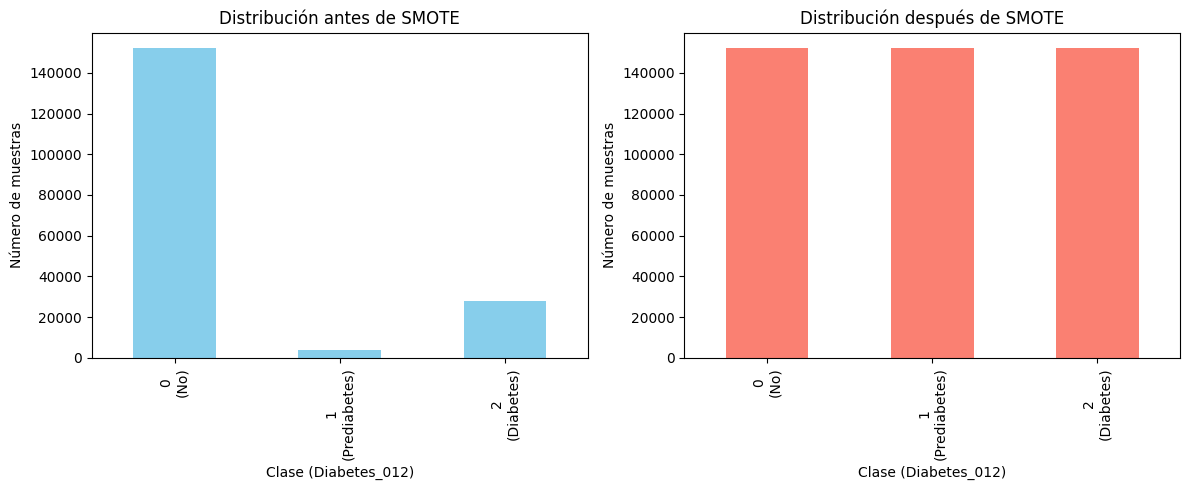

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Asegúrate de tener estas variables ya definidas
# y_train = etiquetas originales antes de SMOTE
# y_train_resampled = etiquetas tras aplicar SMOTE

# Crear DataFrame de frecuencias
df_counts = pd.DataFrame({
    "Antes de SMOTE": pd.Series(y_train).value_counts().sort_index(),
    "Después de SMOTE": pd.Series(y_train_resampled).value_counts().sort_index()
})

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

df_counts["Antes de SMOTE"].plot(kind='bar', ax=axes[0], color="skyblue", title="Distribución antes de SMOTE")
df_counts["Después de SMOTE"].plot(kind='bar', ax=axes[1], color="salmon", title="Distribución después de SMOTE")

for ax in axes:
    ax.set_xlabel("Clase (Diabetes_012)")
    ax.set_ylabel("Número de muestras")
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(["0\n(No)", "1\n(Prediabetes)", "2\n(Diabetes)"])

plt.tight_layout()
plt.show()


## Comparación del balance de clases antes y después de SMOTE

La gráfica anterior muestra la **distribución de clases en la variable objetivo `Diabetes_012`** antes y después de aplicar SMOTE (Synthetic Minority Oversampling Technique).

### Observaciones:

- **Antes de SMOTE:**
  - Clase `0` (No diabetes): dominante, con más de 170.000 muestras.
  - Clase `1` (Prediabetes): muy escasa, apenas unas miles de muestras.
  - Clase `2` (Diabetes): minoritaria, aunque mejor representada que la clase 1.

- **Después de SMOTE:**
  - Las tres clases han sido **igualadas en cantidad** para eliminar el sesgo del modelo hacia la clase mayoritaria.
  - SMOTE ha creado **nuevas observaciones sintéticas** de clases 1 y 2, generadas a partir de sus vecinos más cercanos.

### Justificación del uso de SMOTE

- En el análisis exploratorio (EDA) detectamos un **fuerte desbalance** en los datos.
- El desbalance afecta negativamente a los modelos de clasificación, que tienden a **ignorar las clases minoritarias**.
- SMOTE permite entrenar el modelo en un entorno equilibrado, mejorando la capacidad de predecir correctamente las clases 1 y 2.

> ⚠️ Es importante recordar que SMOTE solo se aplica al conjunto de entrenamiento, nunca al de test, para que la evaluación del modelo se base en datos reales.
---
